In [1267]:
import os
import numpy as np
import scipy as sp
import sounddevice as sd
from audiolazy import lpc
import scipy.signal as sig
import scipy.io.wavfile as wav
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers

from peakutils import peak

In [1281]:
class DatasetVowels:
    def __init__(self):
        
        vowels = {'a':[], 'e':[], 'i':[], 'o':[], 'u':[]}
        for v in vowels.keys():
            path, dirs, files = next(os.walk("./dataset/"+v))
            for f in files:
                if f.endswith('.wav'):
                    vowels[v].append(wav.read('./dataset/'+v+'/'+f))
        
        
        self.data = vowels
        
        vowels = {'a':[], 'e':[], 'i':[], 'o':[], 'u':[]}
        for v in vowels.keys():
            path, dirs, files = next(os.walk("./test_dataset/"+v))
            for f in files:
                if f.endswith('.wav'):
                    vowels[v].append(wav.read('./test_dataset/'+v+'/'+f))
        
        self.test = vowels
        self.max_value = (2**16)/2
        self.min_value = -(((2**16)-1)/2)
        
    def normalized(self, vowel='a'):
        n = []
        for data_v in self.data[vowel]:
            raw_data = data_v[1]
            n.append((raw_data.astype('float') - self.min_value)/(self.max_value - self.min_value))
        return n
    
    def get_envolpe(self, base='base', nw=120):
        formants = {}
        
        if base=='base':
            data = self.data
        else:
            data = self.test
        
        for vowel in ['a', 'e', 'i', 'o', 'u']:
            vowel_formants = []
            
            for i in range(len(data[vowel])):

                v = data[vowel][i][1]

                N = nw
                x = v
                
                x = np.fft.fft(x, 2000)
                x = np.fft.fftshift(x)
                x = np.abs(x)
                f = np.ones((N,))/N

                f[0:int(N/2)] = np.linspace(0, 1./N, N/2)
                f[int(N/2):] = np.linspace(1./N, 0, N/2)

                lpc = np.convolve(x, f, mode='valid')
                
                vowel_formants.append(lpc)
            formants[vowel] = vowel_formants
        return formants
    
    def get_formants(self, base='base', grade=8, how=2):
        nn = 0
        if base == 'base':
            formants = np.zeros((40, how))
            dataset = self.data
        else:
            formants = np.zeros((75, how))
            dataset = self.test
        
        for v in ['a', 'e', 'i', 'o', 'u']:
            for index in range(len(dataset[v])):
                x = dataset[v][index][1]
                max_value = (2**16)/2
                min_value = -(((2**16)-1)/2)

                x = (x.astype('float') - min_value)/(max_value - min_value)

                x = x * np.hamming(len(x))
                pref = np.array([1, .63])

                x = np.convolve(x, pref)

                flt = lpc.acorr(x, grade)

                rts = np.roots(flt.numerator)
                rts = rts[np.imag(rts)>0]

                args = np.argsort(np.angle(rts) * (Fs/(2*np.pi)))

                frqs = np.sort(np.angle(rts) * (Fs/(2*np.pi)))
                
                sd = frqs[:how]
                # sd = np.array([frqs[0], frqs[1], frqs[2], frqs[3]])

                formants[nn, :] = sd
                nn += 1
        return formants
    
    def get_peaks(self, base='base', how=2):
        nn = 0
        Fs = 8000
        if base == 'base':
            peaks = np.zeros((40, how))
            dataset = self.data
        else:
            peaks = np.zeros((75, how))
            dataset = self.test
        
        for v in ['a', 'e', 'i', 'o', 'u']:
            for index in range(len(dataset[v])):
                x = dataset[v][index][1]
                x = (x.astype('float') - min_value)/(max_value - min_value)
                x = np.fft.fft(dataset[v][index][1])
                x = np.fft.fftshift(x)
                x = np.abs(x)
                x = x[int(len(x)/2):]
                
                frq = np.linspace(0, Fs/2, len(x))
                
                p = sig.find_peaks_cwt(x, np.arange(1, 100))
                
                pks = np.argsort(x[p])[::-1]
                peaks[nn, :] = frq[pks][:how]
                nn += 1
                
        return peaks
       
    def get_training_set(self):
        peaks = dataset.get_peaks(base='base', how=2)
        formants = dataset.get_formants(base='base', grade=8, how=2)
        dataset_train = np.concatenate((formants, peaks), axis=1)
        N=8
        labels = [[1,0,0,0,0]]*N + [[0,1,0,0,0]]*N + [[0,0,1,0,0]]*N + \
                 [[0,0,0,1,0]]*N + [[0,0,0,0,1]]*N
        labels = np.asarray(labels)
        
        return dataset_train, labels
    def get_testing_set(self):
        peaks = dataset.get_peaks(base='test', how=2)
        formants = dataset.get_formants(base='test', grade=8, how=2)
        dataset_train = np.concatenate((formants, peaks), axis=1)
        N=15
        labels = [[1,0,0,0,0]]*N + [[0,1,0,0,0]]*N + [[0,0,1,0,0]]*N + \
                 [[0,0,0,1,0]]*N + [[0,0,0,0,1]]*N
        labels = np.asarray(labels)
        
        return dataset_train, labels
    
    
def signal2mat(signal, p):
    a1 = signal
    a1 = a1*2**p
    a1 = a1.astype('int')

    ma1 = (((a1[:,None] & (1 << np.arange(p)))) > 0).astype(int)
    return ma1

In [1282]:
dataset = DatasetVowels()

/usr/local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


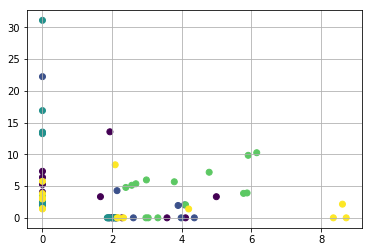

In [1283]:
peaks = dataset.get_peaks(base='test', how=2)
ratio = int(len(peaks)/5)
colors_c = {
    'a': 0.1,
    'e': 0.3,
    'i': 0.5,
    'o': 0.7,
    'u': 0.9
}
colors = np.zeros((len(peaks), )).astype('str')
colors[0:ratio].fill(colors_c['a'])
colors[ratio:ratio*2].fill(colors_c['e'])
colors[ratio*2:ratio*3].fill(colors_c['i'])
colors[ratio*3:ratio*4].fill(colors_c['o'])
colors[ratio*4:].fill(colors_c['u'])

plt.scatter(peaks[:, 0], peaks[:, 1], c=colors)
plt.grid()

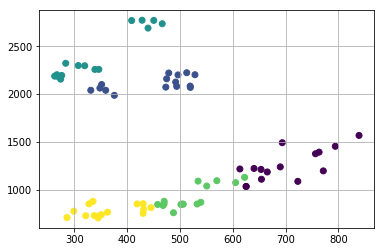

In [1028]:
formants = dataset.get_formants(base='test', grade=8, how=2)
ratio = int(len(formants)/5)
colors_c = {
    'a': 0.1,
    'e': 0.3,
    'i': 0.5,
    'o': 0.7,
    'u': 0.9
}
colors = np.zeros((len(formants), )).astype('str')
colors[0:ratio].fill(colors_c['a'])
colors[ratio:ratio*2].fill(colors_c['e'])
colors[ratio*2:ratio*3].fill(colors_c['i'])
colors[ratio*3:ratio*4].fill(colors_c['o'])
colors[ratio*4:].fill(colors_c['u'])

plt.scatter(formants[:, 0], formants[:, 1], c=colors)
plt.grid()

In [1035]:
X_train, Y_train = dataset.get_training_set()
X_test, Y_test = dataset.get_testing_set()

In [1152]:
model = Sequential([
    Dense(200, input_shape=(4,)),
    Activation('sigmoid'),
    Dense(500),
    Activation('sigmoid'),
    Dense(100),
    Activation('sigmoid'),
    Dense(200),
    Activation('sigmoid'),
    Dense(100),
    Activation('sigmoid'),
    Dense(5),
    Activation('softmax'),
])

adam = optimizers.Adagrad(lr=0.001)

model.compile(optimizer=adam,
              loss='mse',
              metrics=['accuracy'])

In [1153]:
hist = model.fit(X_train, Y_train, epochs=10000, batch_size=30, verbose=0)

In [1154]:
model.evaluate(X_train, Y_train)

40/40 [==============================] - 1s 22ms/step


[0.071127648651599887, 0.82499999999999996]

In [1155]:
model.evaluate(X_test, Y_test)

75/75 [==============================] - 0s 189us/step


[0.086502257585525516, 0.71999999920527136]

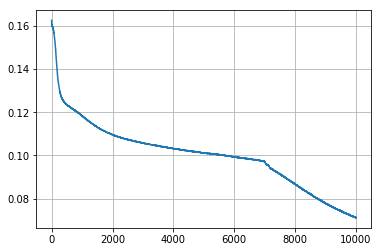

In [1156]:
plt.plot(hist.history['loss'])
plt.grid()

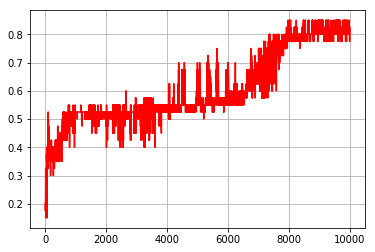

In [1157]:
plt.plot(hist.history['acc'], 'r')
plt.grid()

In [1170]:
def get_one_hot(pred):
    onehot = np.zeros_like(pred)
    for i in range(len(pred)):
        a = np.zeros_like(pred[i, :])
        a[np.argmax(pred[i, :])] = 1
        onehot[i, :] = a 
    return onehot

In [1204]:
p = model.predict(X_test)

In [1346]:
def predict_vowel():
    import sounddevice as sd
    import time
    
    print("3")
    time.sleep(1)
    print("2")
    time.sleep(1)
    print("1")
    
    duration = 1.0
    print(f"Tienes {duration} segundos...")
    sd.default.device = 0
    f = 8000
    
    record = sd.rec(int(duration * fs), samplerate=fs, channels=1)
    time.sleep(2)
    print("Analizando...")
    
    grade = 8
    how = 2
    
    start = time.time()
    x = record.T.reshape((-1, ))
    max_value = (2**16)/2
    min_value = -(((2**16)-1)/2)

    x = (x.astype('float') - min_value)/(max_value - min_value)

    x = x * np.hamming(len(x))
    pref = np.array([1, .63])

    x = np.convolve(x, pref)

    flt = lpc.acorr(x, grade)

    rts = np.roots(flt.numerator)
    rts = rts[np.imag(rts)>0]

    args = np.argsort(np.angle(rts) * (Fs/(2*np.pi)))

    frqs = np.sort(np.angle(rts) * (Fs/(2*np.pi)))

    sdx = frqs[:how]
    # sd = np.array([frqs[0], frqs[1], frqs[2], frqs[3]])

    formants = sdx
    
    x = record
    x = record.T.reshape((-1, ))
    x = (x.astype('float') - min_value)/(max_value - min_value)
    
    x = np.fft.fft(x)
    x = np.fft.fftshift(x)
    x = np.abs(x)
    x = x[int(len(x)/2):]

    frq = np.linspace(0, Fs/2, len(x))

    p = sig.find_peaks_cwt(x, np.arange(1, 100))

    pks = np.argsort(x[p])[::-1]
    peaks = frq[pks][:how]
        
    features = np.array([[formants[0], formants[1], peaks[0], peaks[1]]]).reshape((-1,4))
    
    r = model.predict(features)
    
    end_ = time.time()

    print(r)
    supp = np.zeros_like(r)
    supp[0,np.argmax(r)] = 1
    plt.plot(record)
    print(supp)
    
    print(end_ - start)

3
2
1
Tienes 1.0 segundos...
Analizando...
[[ 0.17613782  0.05044239  0.00621546  0.56642419  0.20078018]]
[[ 0.  0.  0.  1.  0.]]
0.743865966796875


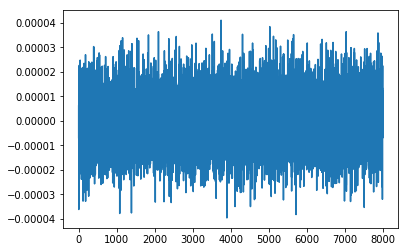

In [1347]:
predict_vowel()

In [1311]:
X_train.shape

(40, 4)